In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


rows,cols=(224,224)


#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (rows,cols))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


torch.Size([1, 3, 224, 224])
label=388


In [3]:
def infer_img(img,t=0):
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
    
    
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    #print("label={}".format(label))
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    
    #print("{}={}".format(t,pro))
    return pro

In [4]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))

0.9270878
3.1756701e-06
0.9270878


rotate=0 pro[388]=0.9270877838134766
rotate=10 pro[388]=0.8775543570518494
rotate=20 pro[388]=0.7659257054328918
rotate=30 pro[388]=0.9029491543769836
rotate=40 pro[388]=0.8248783946037292
rotate=50 pro[388]=0.776427149772644
rotate=60 pro[388]=0.518994927406311
rotate=70 pro[388]=0.38380444049835205
rotate=80 pro[388]=0.2292323112487793
rotate=90 pro[388]=0.66794353723526
rotate=100 pro[388]=0.5489585995674133
rotate=110 pro[388]=0.5743719935417175
rotate=120 pro[388]=0.1295001208782196
rotate=130 pro[388]=0.20743101835250854
rotate=140 pro[388]=0.059947557747364044
rotate=150 pro[388]=0.05525680258870125
rotate=160 pro[388]=0.15112358331680298
rotate=170 pro[388]=0.07850375771522522


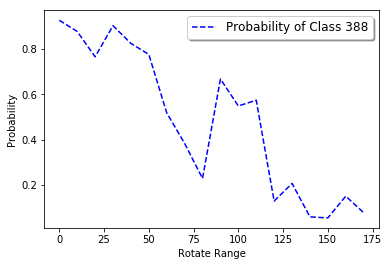

In [5]:
#验证原始图片的旋转不变性
rotate_range = range(0,180,10)
original_pro = []

for i in rotate_range:
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
    rotate_img = cv2.warpAffine(orig.copy(),matrix,(cols,rows))
    pro=infer_img(rotate_img.copy(),388)
    print("rotate={} pro[388]={}".format(i,pro))
    original_pro += [pro]

fig, ax = plt.subplots()
ax.plot(np.array(rotate_range), np.array(original_pro), 'b--', label='Probability of Class 388')
#ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Rotate Range')
plt.ylabel('Probability')
plt.show()

In [6]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.007

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    
    # forward + backward
    #output = model(img)
    output = F.softmax(model(img),dim=1)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    pro=output.data.cpu().numpy()[0][label]
    
    print("epoch={} loss={} label={} pro={}".format(epoch,loss,label,pro))
    
    #如果定向攻击成功 并且概率大于阈值
    if (label == target) and ( pro > 0.80):
        print("")
        break
         
    #梯度清零
    optimizer.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    
    img.data=img.data-e*torch.sign(img.grad.data)


epoch=0 loss=6.909350872039795 label=388 pro=0.9270877838134766
epoch=1 loss=6.908728122711182 label=388 pro=0.13656507432460785
epoch=2 loss=6.907952785491943 label=387 pro=0.08568044751882553
epoch=3 loss=6.899841785430908 label=219 pro=0.05838492140173912
epoch=4 loss=6.81821346282959 label=293 pro=0.11074680835008621
epoch=5 loss=6.628979682922363 label=288 pro=0.2798868715763092
epoch=6 loss=6.544139385223389 label=288 pro=0.36470136046409607
epoch=7 loss=6.411447048187256 label=288 pro=0.4975048899650574
epoch=8 loss=6.155745506286621 label=288 pro=0.753385603427887
epoch=9 loss=6.044737339019775 label=288 pro=0.8645306825637817



In [7]:
#把对抗样本转换成正常图片
adv=img.data.cpu().numpy()[0]
print(adv.shape)

adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

print(adv.shape)

(3, 224, 224)
(224, 224, 3)


(224, 224, 3)


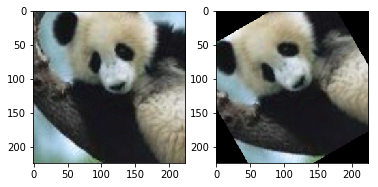

In [8]:
# 得到变换的矩阵，通过这个矩阵再利用warpAffine来进行变换
# 第一个参数就是旋转中心，元组的形式，这里设置成相片中心
# 第二个参数90，是旋转的角度
# 第三个参数1，表示放缩的系数，1表示保持原图大小
matrix = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
img2 = cv2.warpAffine(adv,matrix,(cols,rows))

print(img2.shape)


plt.subplot(121)
plt.imshow(adv) 

plt.subplot(122)
plt.imshow(img2) 


plt.show() 

rotate=0 pro[388]=3.845690662274137e-05 pro[288]=0.8555896282196045
rotate=10 pro[388]=0.7470769286155701 pro[288]=6.841963477199897e-05
rotate=20 pro[388]=0.7902793884277344 pro[288]=2.3604578018421307e-05
rotate=30 pro[388]=0.909116804599762 pro[288]=2.0972451238776557e-05
rotate=40 pro[388]=0.7858207821846008 pro[288]=3.100634421571158e-05
rotate=50 pro[388]=0.8502417802810669 pro[288]=1.119178250519326e-05
rotate=60 pro[388]=0.8026388883590698 pro[288]=1.4884611118759494e-05
rotate=70 pro[388]=0.5404626131057739 pro[288]=2.7346763090463355e-05
rotate=80 pro[388]=0.4158894419670105 pro[288]=0.0001339470036327839
rotate=90 pro[388]=0.6717212200164795 pro[288]=0.001942582312040031
rotate=100 pro[388]=0.6170642375946045 pro[288]=0.00017524874419905245
rotate=110 pro[388]=0.6434752345085144 pro[288]=0.00032343302154913545
rotate=120 pro[388]=0.2558012902736664 pro[288]=0.00026954480563290417
rotate=130 pro[388]=0.4244200885295868 pro[288]=0.00015607666864525527
rotate=140 pro[388]=0.151

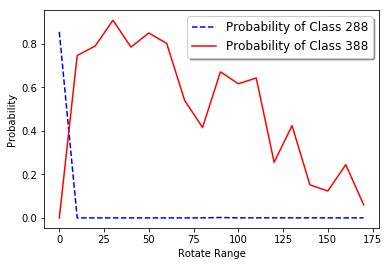

In [9]:
#验证旋转对 对抗样本的影响
rotate_range = range(0,180,10)
adv_288_pro = []
adv_388_pro = []

for i in rotate_range:
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
    rotate_img = cv2.warpAffine(adv.copy(),matrix,(cols,rows))
    pro_388=infer_img(rotate_img.copy(),388)
    pro_288=infer_img(rotate_img.copy(),288)
    print("rotate={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(rotate_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(rotate_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Rotate Range')
plt.ylabel('Probability')
plt.show()

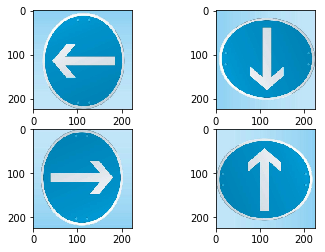

In [10]:
def show_right():
    #图像加载以及预处理
    image_path="../picture/left.jpg"
    img = cv2.imread(image_path)[..., ::-1]
    img = cv2.resize(img, (rows,cols))
    #img = img.transpose(2, 0, 1)
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
    img1 = cv2.warpAffine(img,matrix,(cols,rows))

    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
    img2 = cv2.warpAffine(img,matrix,(cols,rows))
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),270,1)
    img3 = cv2.warpAffine(img,matrix,(cols,rows))



    plt.subplot(221)
    plt.imshow(img) 

    plt.subplot(222)
    plt.imshow(img1) 
    
    plt.subplot(223)
    plt.imshow(img2) 
    
    plt.subplot(224)
    plt.imshow(img3) 


    plt.show() 

show_right()

rotate=0 adv_pro[388]=3.845690662274137e-05 original_pro[388]=0.9270877838134766
rotate=10 adv_pro[388]=0.7470769286155701 original_pro[388]=0.8775543570518494
rotate=20 adv_pro[388]=0.7902793884277344 original_pro[388]=0.7659257054328918
rotate=30 adv_pro[388]=0.909116804599762 original_pro[388]=0.9029491543769836
rotate=40 adv_pro[388]=0.7858207821846008 original_pro[388]=0.8248783946037292
rotate=50 adv_pro[388]=0.8502417802810669 original_pro[388]=0.776427149772644
rotate=60 adv_pro[388]=0.8026388883590698 original_pro[388]=0.518994927406311
rotate=70 adv_pro[388]=0.5404626131057739 original_pro[388]=0.38380444049835205
rotate=80 adv_pro[388]=0.4158894419670105 original_pro[388]=0.2292323112487793
rotate=90 adv_pro[388]=0.6717212200164795 original_pro[388]=0.66794353723526
rotate=100 adv_pro[388]=0.6170642375946045 original_pro[388]=0.5489585995674133
rotate=110 adv_pro[388]=0.6434752345085144 original_pro[388]=0.5743719935417175
rotate=120 adv_pro[388]=0.2558012902736664 original_

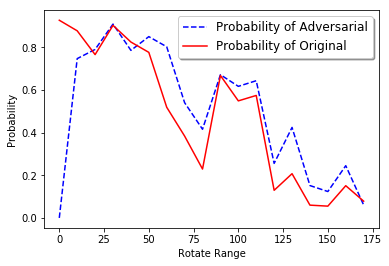

In [11]:
#综合分析验证旋转对 对抗样本和正常图片分类的影响
rotate_range = range(0,180,10)
original_pro = []
adv_pro = []

for i in rotate_range:
    
    matrix = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
    
    rotate_adv_img = cv2.warpAffine(adv.copy(),matrix,(cols,rows))
    pro_388=infer_img(rotate_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    rotate_img = cv2.warpAffine(orig.copy(),matrix,(cols,rows))
    pro=infer_img(rotate_img.copy(),388)
    original_pro += [pro]
            
    print("rotate={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(rotate_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(rotate_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Rotate Range')
plt.ylabel('Probability')
plt.show()